# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import os
import io
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# File Path
Azdias_file_path = '/Users/nyaribomaseru/Documents/AWS_Sagemaker_Deployment/Bertelsmann_Arvato_Project/data/Udacity_AZDIAS_052018.csv'
Customers_file_path = '/Users/nyaribomaseru/Documents/AWS_Sagemaker_Deployment/Bertelsmann_Arvato_Project/data/Udacity_CUSTOMERS_052018.csv'
AZDIAS_Feature_Summary_path = '/Users/nyaribomaseru/Documents/AWS_Sagemaker_Deployment/Bertelsmann_Arvato_Project/data/AZDIAS_Feature_Summary.csv'
Dias_Attributes_file_path = '/Users/nyaribomaseru/Documents/AWS_Sagemaker_Deployment/Bertelsmann_Arvato_Project/DIAS Attributes - Values 2017.xlsx'
Dias_Info_file_path = '/Users/nyaribomaseru/Documents/AWS_Sagemaker_Deployment/Bertelsmann_Arvato_Project/DIAS Information Levels - Attributes 2017.xlsx'


In [3]:
Azdias = pd.read_csv(Azdias_file_path, sep=';', low_memory=False )
Azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [4]:
Customers = pd.read_csv(Customers_file_path, sep=';', low_memory=False )
Customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [5]:
AZDIAS_Feature_Summary = pd.read_csv(AZDIAS_Feature_Summary_path, sep=';', low_memory=False )
AZDIAS_Feature_Summary.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [6]:
Dias_Attributes = pd.read_excel(Dias_Attributes_file_path, skiprows=0,index_col=0, header=1)
Dias_Attributes.head()

,Attribute,Description,Value,Meaning
NaN,AGER_TYP,best-ager typology,-1,unknown
NaN,NaN,NaN,0,no classification possible
NaN,NaN,NaN,1,passive elderly
NaN,NaN,NaN,2,cultural elderly
NaN,NaN,NaN,3,experience-driven elderly


In [7]:
Dias_Info = pd.read_excel(Dias_Info_file_path, skiprows=0,index_col=0, header=1)
Dias_Info.head()

,Information level,Attribute,Description,Additional notes
NaN,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
NaN,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
NaN,NaN,ANREDE_KZ,gender,NaN
NaN,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
NaN,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...


In [8]:
# Make a copy of the Main dataframe to use
Azdias_df = Azdias.copy()
Customers_df = Customers.copy()

In [9]:
Azdias_df.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [10]:
Customers_df.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [11]:
# Remove NaN from Dias_Attributes and reset the index to 0
Dias_Attributes.dropna(inplace=True)
Dias_Attributes = Dias_Attributes.reset_index(drop=True)

Dias_Info = Dias_Info.reset_index(drop='index')

print('\nThe number of Features in AZDIAS_Feature_Summary File is {}'.format(AZDIAS_Feature_Summary.shape[0]))
print('\nThe number of Features in Dias_Attribute File is {}'.format(Dias_Attributes.shape[0]))
print('\nThe number of Features in Dias_Information File is {}'.format(Dias_Info.shape[0]))


The number of Features in AZDIAS_Feature_Summary File is 85

The number of Features in Dias_Attribute File is 314

The number of Features in Dias_Information File is 313


#### Explore Features Summary for AZDIAS_Feature_Summary from the first project in Term 1 with the New dataset

In [12]:
# Display Feature summary

display(AZDIAS_Feature_Summary.groupby(['type', 'missing_or_unknown']).size().reset_index(name='Count'))

,type,missing_or_unknown,Count
0,categorical,"[-1,0]",5
1,categorical,"[-1,9]",1
2,categorical,"[-1,X]",1
3,categorical,[-1],6
4,categorical,[0],5
5,categorical,[XX],1
6,categorical,[],2
7,interval,[0],1
8,mixed,"[-1,0]",3
9,mixed,"[-1,XX]",1


In [13]:
# Check whats new on the Dias_Attributes from AZDIAS_Feature_Summary
Dias_Attributes = Dias_Attributes[~Dias_Attributes['Attribute'].isin(AZDIAS_Feature_Summary.attribute)]
Dias_Attributes = Dias_Attributes.reset_index(drop=True)
Dias_Attributes.head()

,Attribute,Description,Value,Meaning
0,BIP_FLAG,business-flag indicating companies in the buil...,-1,unknown
1,CAMEO_DEUINTL_2015,CAMEO classification 2015 - international typo...,-1,unknown
2,D19_BANKEN_ANZ_12,transaction activity BANKS in the last 12 months,0,no transactions known
3,D19_BANKEN_ANZ_24,transaction activity BANKS in the last 24 months,0,no transactions known
4,D19_BANKEN_DATUM,actuality of the last transaction for the segm...,1,highest activity within the last 12 months


In [14]:
# Check shape
print('\nThe number of Features in Dias_Attribute File is {}'.format(Dias_Attributes.shape[0]))


The number of Features in Dias_Attribute File is 233


In [15]:
# Display count by Meaning and Value
Dias_Attributes.groupby(['Meaning', 'Value']).size().reset_index(name='Count')

,Meaning,Value,Count
0,Universal,1,1
1,highest activity within the last 12 months,1,12
2,no Online-transactions within the last 12 months,0,3
3,no transaction known,0,34
4,no transactions known,0,10
5,unknown,-1,111
6,unknown,"-1, 0",3
7,unknown,"-1, 9",58
8,very low car quote,1,1


In [16]:
# Generate a New Summary_feat dataframe 
def create_new_summary_features(Azdias_df, Dias_Attributes):
    # Check values on Azdias_df to add to new summary file. 
    # Add new column 'type' and 'missing_or_unknown'
    # Drop columns 'Description', 'Value', 'Meaning'
    
    OBJECT_VAL = lambda x: [str(k) for k in str(x).split(',')]

    # Check and map meaning for 'unknown' values on Azdias
    unknown_meaning = Dias_Attributes[Dias_Attributes['Meaning'] == 'unknown']
    unknown_meaning = unknown_meaning[unknown_meaning['Attribute'].isin(Azdias_df.columns)]
    
    unknown_meaning['type'] = 'ordinal'
    unknown_meaning['missing_or_unknown'] = unknown_meaning['Value'].apply(OBJECT_VAL)

    unknown_meaning.drop(['Description', 'Value', 'Meaning'], axis=1, inplace=True)
    unknown_meaning.columns = ['attribute', 'type', 'missing_or_unknown']

    # Check and map meaning for 'no_transaction_meaning' values on Azdias
    no_transaction_meaning = Dias_Attributes[Dias_Attributes['Meaning'].isin(['no transaction known', 'no transactions known'])]
    no_transaction_meaning = no_transaction_meaning[no_transaction_meaning['Attribute'].isin(Azdias_df.columns)]

    no_transaction_meaning['type'] = 'ordinal'
    no_transaction_meaning['missing_or_unknown'] = no_transaction_meaning['Value'].apply(lambda x: [str(x)])

    no_transaction_meaning.drop(['Description', 'Value', 'Meaning'], axis=1, inplace=True)
    no_transaction_meaning.columns = ['attribute', 'type', 'missing_or_unknown']

    # Check and map meaning for 'remaining_vals_meaning' values on Azdias
    remaining_vals_meaning = Dias_Attributes[~Dias_Attributes['Meaning'].isin(['unknown',
                                                                               'no transaction known', 
                                                                               'no transactions known'])]
    remaining_vals_meaning = remaining_vals_meaning[remaining_vals_meaning['Attribute'].isin(Azdias_df.columns)]
    remaining_vals_meaning['type'] = remaining_vals_meaning['Meaning'].apply(lambda x: 'categorical' if x == 'Universal' else 'ordinal')
    remaining_vals_meaning['missing_or_unknown'] = remaining_vals_meaning['Value'].apply(lambda x: [])

    remaining_vals_meaning.drop(['Description', 'Value', 'Meaning'], axis=1, inplace=True)
    remaining_vals_meaning.columns = ['attribute', 'type', 'missing_or_unknown']
    
    # Update AZDIAS_Feature_Summary
    AZDIAS_Feature_Summary['missing_or_unknown'] = AZDIAS_Feature_Summary['missing_or_unknown'].apply(lambda x: x[1: -1].split(','))
    
    # Drop column
    AZDIAS_Feature_Summary.drop(['information_level'], axis=1, inplace=True)
    summary_info = pd.concat([AZDIAS_Feature_Summary, remaining_vals_meaning, no_transaction_meaning, unknown_meaning],sort=False, ignore_index=True)
    
    return summary_info

feat_Info = create_new_summary_features(Azdias_df, Dias_Attributes)

In [17]:
# Check shape
feat_Info.shape

(276, 3)

In [18]:
feat_Info.type.value_counts()

ordinal        239
categorical     22
numeric          7
mixed            7
interval         1
Name: type, dtype: int64

In [19]:
# Check on columns without Type value in Azdias_df
cols = Azdias_df.columns[~Azdias_df.columns.isin(feat_Info.attribute)]

check_cols_dtypes = Azdias_df[cols].select_dtypes(include='object')
check_cols_dtypes.head()


,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM
0,NaN,NaN
1,NaN,1992-02-10 00:00:00
2,D19_UNBEKANNT,1992-02-12 00:00:00
3,D19_UNBEKANNT,1997-04-21 00:00:00
4,D19_SCHUHE,1992-02-12 00:00:00


In [20]:
describe = Azdias_df[cols].describe()
describe

,LNR,AKT_DAT_KL,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_KINDER,ANZ_STATISTISCHE_HAUSHALTE,CJT_KATALOGNUTZER,...,STRUKTURTYP,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11
count,8.912210e+05,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,817722.000000,798073.000000,886367.000000,...,793947.000000,793435.000000,793435.000000,817722.000000,793947.00000,817722.00000,770025.000000,815304.000000,815304.000000,815304.000000
mean,6.372630e+05,4.421928,11.745392,13.402658,14.476013,15.089627,13.700717,0.154018,7.599356,3.335264,...,2.539212,3.223125,4.017526,0.090067,4.58576,0.43882,2.417322,6.001214,7.532130,5.945972
std,2.572735e+05,3.638805,4.097660,3.243300,2.712427,2.452932,5.079849,0.502389,14.332201,1.493633,...,0.754926,1.255785,1.118399,0.286278,8.47152,1.14329,1.166572,2.856091,3.247789,2.771464
min,1.916530e+05,1.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,0.000000,1.000000,...,1.000000,1.000000,1.000000,0.000000,0.00000,0.00000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,1.000000,8.000000,11.000000,13.000000,14.000000,11.000000,0.000000,1.000000,2.000000,...,2.000000,2.000000,3.000000,0.000000,0.00000,0.00000,2.000000,3.000000,5.000000,4.000000
50%,6.372630e+05,3.000000,12.000000,14.000000,15.000000,15.000000,14.000000,0.000000,3.000000,4.000000,...,3.000000,3.000000,4.000000,0.000000,1.00000,0.00000,2.000000,6.000000,8.000000,6.000000
75%,8.600680e+05,9.000000,15.000000,16.000000,17.000000,17.000000,17.000000,0.000000,9.000000,5.000000,...,3.000000,4.000000,5.000000,0.000000,5.00000,0.00000,3.000000,9.000000,10.000000,8.000000
max,1.082873e+06,9.000000,18.000000,18.000000,18.000000,18.000000,25.000000,11.000000,449.000000,5.000000,...,3.000000,5.000000,5.000000,1.000000,45.00000,5.00000,4.000000,11.000000,13.000000,11.000000


In [21]:
# Check on columns without type value in Azdias_df from Dias_info df
dias_info = Dias_Info[Dias_Info['Attribute'].isin(cols)]
display(dias_info)


,Information level,Attribute,Description,Additional notes
67,NaN,D19_VERSI_OFFLINE_DATUM,actuality of the last transaction for the segm...,NaN
68,NaN,D19_VERSI_ONLINE_DATUM,actuality of the last transaction for the segm...,NaN
69,NaN,D19_VERSI_DATUM,actuality of the last transaction for the segm...,NaN


In [22]:
cols_to_drop = list(check_cols_dtypes)
cols_to_drop

['D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM']

In [23]:
last_att_info = pd.DataFrame({'attribute': list(describe.columns)})
last_att_info['type'] = 'numeric'
last_att_info['missing_or_unknown'] = last_att_info['type'].apply(lambda x: [])
last_att_info.head()

,attribute,type,missing_or_unknown
0,LNR,numeric,[]
1,AKT_DAT_KL,numeric,[]
2,ALTER_KIND1,numeric,[]
3,ALTER_KIND2,numeric,[]
4,ALTER_KIND3,numeric,[]


In [24]:
# Concat last_att_info and summary_feat_info
summary_feat_df = pd.concat([feat_Info, last_att_info], ignore_index=True)
print('\nThe number of Features in summary_feat_df is {}'.format(summary_feat_df.shape[0]))


The number of Features in summary_feat_df is 364


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

# Step 1: Preprocessing
### Step 1.1: Assess Missing Data

The summary_df contains a summary of properties for each demographics data column. This file is to helpmake cleaning decisions during this stage of the project. First i shall assess the demographics data in terms of missing data.

In [25]:
summary_feat_df.head()

,attribute,type,missing_or_unknown
0,AGER_TYP,categorical,"[-1, 0]"
1,ALTERSKATEGORIE_GROB,ordinal,"[-1, 0, 9]"
2,ANREDE_KZ,categorical,"[-1, 0]"
3,CJT_GESAMTTYP,categorical,[0]
4,FINANZ_MINIMALIST,ordinal,[-1]


In [26]:
# # Save Clean Data model to use later
# import pickle
# summary_feat_df = summary_feat_df

# filename = 'summary_feat_df.sav'
# pickle.dump(summary_feat_df, open(filename, 'wb'))

In [27]:
# Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value
for i, row in summary_feat_df.iterrows():
    name = row['attribute']
    item_features = Azdias_df[name]
    
    if row['missing_or_unknown'] != '[]':
        items = str(row['missing_or_unknown'])[1: -1].split(',')
    else:
        items = []
    if items:
        for item in items:
            try:
                item_features = item_features.replace([int(item)], np.NaN)
            except:
                item_features = item_features.replace([item], np.NaN)
                
    Azdias_df[name] = item_features

In [28]:
# Drop 3 columns that are Not found in the summary_feat_df
Azdias_df.drop(cols_to_drop, axis=1, inplace=True)

### Step 1.1.2: Assess Missing Data in Each Column

In [29]:
print("Demographics data for the general population of Germany is {} persons (rows)".format(Azdias_df.shape[0]))
print("Total number of features is {} (columns):".format(Azdias_df.shape[1]))

Demographics data for the general population of Germany is 891221 persons (rows)
Total number of features is 364 (columns):


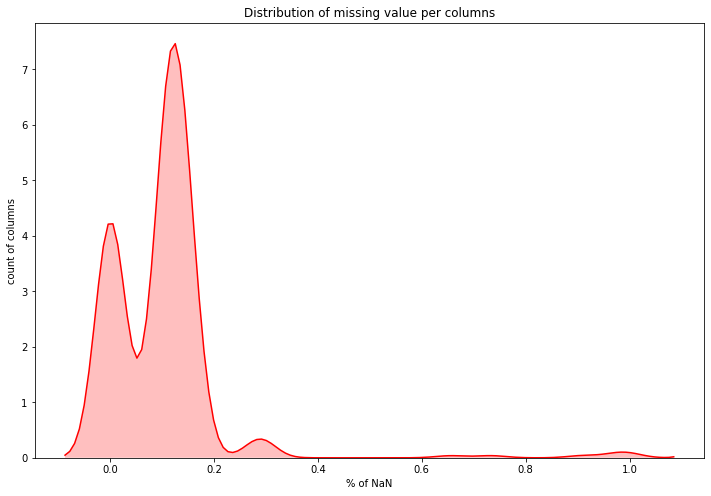

In [30]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

# proportion in % of NaN values
count_nan_col = Azdias_df.isna().sum() / len(Azdias_df)

# Plot the propotion
fig = plt.figure(figsize=(12,8))
sns.kdeplot(count_nan_col.values,shade=True, color="r")
plt.ylabel('count of columns')
plt.xlabel('% of NaN')
plt.title('Distribution of missing value per columns')
plt.show()

##### Note on Missing values on columns: 
* Most NaN Values fall above > 30% of the features columns. Thus ill shall drop columns above 30%.

In [31]:
# Get columns above 30%
above_30_pct = count_nan_col[count_nan_col > 0.3]
to_drop = list(above_30_pct.index)
print('\nNumber of columns to drop that are above 30% is ',len(to_drop))
print('\nColumns to drop that are: ', to_drop)


Number of columns to drop that are above 30% is  6

Columns to drop that are:  ['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'KK_KUNDENTYP']


In [32]:
# Remove outlier columns from the dataset
Azdias_df.drop(columns=to_drop, axis=1, inplace=True)
Azdias_df.shape

(891221, 358)

### Step 1.1.3: Assess Missing Data in Each Row

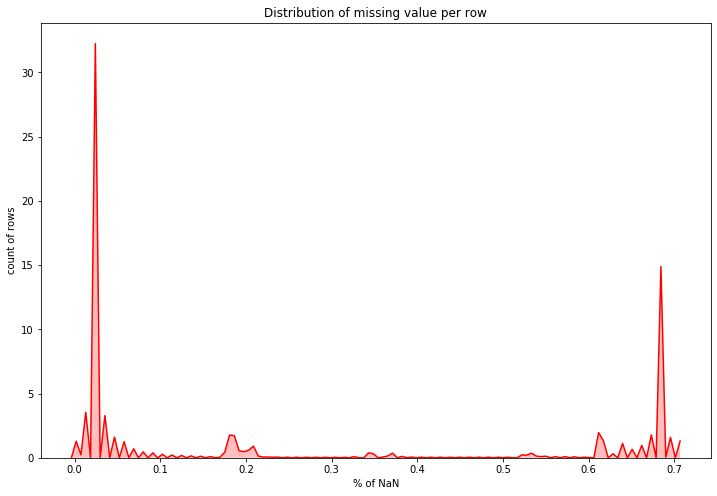

In [33]:
# Missing data in each row
count_nan_row = Azdias_df.isna().sum(axis = 1)

# Plot the propotion

fig = plt.figure(figsize=(12,8))
sns.kdeplot(count_nan_row.values / 357,shade=True, color="r")
plt.ylabel('count of rows')
plt.xlabel('% of NaN')
plt.title('Distribution of missing value per row')
plt.show()

##### Note on Missing values on Rows: 
* Most NaN Values fall below <= 50% of the rows. Thus ill shall drop rows <= 50% from the dataframe

In [34]:
# Remove outlier rows from the dataset
Azdias_df = Azdias_df.loc[count_nan_row[count_nan_row <= 0.5 * 357].index]
Azdias_df.reset_index(drop=True, inplace=True)
Azdias_df.shape

(791987, 358)

In [35]:
Azdias_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 791987 entries, 0 to 791986
Columns: 358 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(261), int64(93), object(4)
memory usage: 2.1+ GB


In [36]:
Azdias_df.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910220,-1,9.0,0.0,21.0,11.0,0.0,0.0,2.0,12.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
1,910225,-1,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
2,910226,2,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
3,910241,-1,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3
4,910244,3,1.0,10.0,10.0,5.0,0.0,0.0,1.0,2.0,...,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4,2,1


### Step 1.2.1: Re-Encode Categorical Features

In [37]:
# summary_feat_df.head()
feat_df = summary_feat_df[summary_feat_df['attribute'].isin(Azdias_df.columns)]
len(feat_df)

358

In [38]:
feat_df.type.value_counts()

ordinal        239
numeric         90
categorical     21
mixed            7
interval         1
Name: type, dtype: int64

### Step 1.2.1: Re-Encode Categorical Features

For categorical data, Depending on the number of categories, perform one of the following:
1. For binary (two-level) categoricals that take numeric values, i shall keep them without needing to do anything. If there is one binary variable that takes on non-numeric values, i shall re-encode the values as numbers or create a dummy variable.

2. For multi-level categoricals (three or more values), i shall choose to encode the values using multiple dummy variables (e.g. via OneHotEncoder), or (to keep things straightforward) just drop them from the analysis.

In [39]:
count_type = feat_df.type.value_counts()
df_type = pd.DataFrame(count_type.values, index=count_type.index, columns=['Count_columns'])
df_type

,Count_columns
ordinal,239
numeric,90
categorical,21
mixed,7
interval,1


In [40]:
# Get Categorical Features

cat_feat = feat_df['attribute'][feat_df['type'] == 'categorical']
# cat_feat

binary_str_attribute = []
binary_num_attribute = []
multi_level_attribute = []

for att in cat_feat:
    dtype = Azdias_df[att].dtype
    count = len(Azdias_df[att].value_counts())
    
    if count > 3:
        multi_level_attribute.append(att)
    else:
        if dtype == 'object':
            binary_str_attribute.append(att)
        else:
            binary_num_attribute.append(att)
            


In [41]:
# Binary_String columns are:
binary_str_attribute


['OST_WEST_KZ']

In [42]:
# Binary_Numeric columns are:
binary_num_attribute

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP']

In [43]:
# Multi_level_attribute columns are:
multi_level_attribute

['AGER_TYP',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'TITEL_KZ',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015',
 'D19_KONSUMTYP']

In [44]:
# Re encode Binary_String as a dummy variable:
Azdias_df.replace({'OST_WEST_KZ': {'W': 1, 'O': 2}}, inplace=True)

In [45]:
# Re encode Multi_level_attribute column:
def encode_cat(df, feature):
    dummy_df = []
    
    for name in feature:
        dummy_df.append(pd.get_dummies(df[name], prefix=name))
    
    assert len(dummy_df) == len(feature)
    
    # drop feature from df
    df.drop(feature, axis=1, inplace=True)
    dummy_df.append(df)
    df = pd.concat(dummy_df, axis=1)
    
    return df

New_Azdias_df = encode_cat(Azdias_df, multi_level_attribute)

### Step 1.2.2: Engineer Mixed-Type Features


    There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:

    "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.

    "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
    If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

In [46]:
# Get Mixedl Features

mixed_feat = list(feat_df['attribute'][feat_df['type'] == 'mixed'])
mixed_feat

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'KBA05_BAUMAX',
 'PLZ8_BAUMAX']

In [47]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

# Map Decade
dict_decade = {1: 40, 2: 40, 3: 50, 4: 50, 5: 60, 6: 60, 7: 60,8: 70, 9: 70, 10: 80, 
               11: 80, 12: 80, 13: 80, 14: 90, 15: 90, 
               np.NaN: np.NaN, -1: np.NaN, 0: np.NaN}

# Map Movement 
# Mainstream : 0, Avantgarde : 1
dict_movement = {1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 
                 6: 1, 7: 1, 8: 0, 9: 1, 10: 0, 
                 11: 1, 12: 0, 13: 1, 14: 0, 15: 1, 
                 np.NaN: np.NaN, -1: np.NaN, 0: np.NaN}

# Add Re_encoded columns
New_Azdias_df['PRAEGENDE_JUGENDJAHRE_Decade'] = New_Azdias_df['PRAEGENDE_JUGENDJAHRE'].map(dict_decade)
New_Azdias_df['PRAEGENDE_JUGENDJAHRE_Movemnet'] = New_Azdias_df['PRAEGENDE_JUGENDJAHRE'].map(dict_movement)

# Drop PRAEGENDE_JUGENDJAHRE after endoning
New_Azdias_df.drop('PRAEGENDE_JUGENDJAHRE',axis= 1, inplace=True)

In [48]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
# Create a function that split the values in 0s and 1s
def get_wealth(x):
    try:
        x = str(x)
        return int(x[0])
    except:
        return np.NaN
    
def get_life_stage(x):
    try:
        x = str(x)
        return int(x[1])
    except:
        return np.NaN


# Map new CAMEO_INTL_2015_wealth with value = 0
# Map new CAMEO_INTL_2015_Life_stage with value = 1
New_Azdias_df['CAMEO_INTL_2015_Wealth'] = New_Azdias_df['CAMEO_INTL_2015'].apply(lambda x: get_wealth(x))
New_Azdias_df['CAMEO_INTL_2015_Life_stage'] = New_Azdias_df['CAMEO_INTL_2015'].apply(lambda x: get_life_stage(x))

# Drop 'CAMEO_INTL_2015' after encoding 
New_Azdias_df.drop('CAMEO_INTL_2015',axis= 1, inplace=True)


In [49]:
# Investigate "LP_LEBENSPHASE_FEIN" and engineer two new variables.

# Map life_stage
life_stage = {1: 'younger_age', 2: 'middle_age', 3: 'younger_age',
              4: 'middle_age', 5: 'advanced_age', 6: 'retirement_age',
              7: 'advanced_age', 8: 'retirement_age', 9: 'middle_age',
              10: 'middle_age', 11: 'advanced_age', 12: 'retirement_age',
              13: 'advanced_age', 14: 'younger_age', 15: 'advanced_age',
              16: 'advanced_age', 17: 'middle_age', 18: 'younger_age',
              19: 'advanced_age', 20: 'advanced_age', 21: 'middle_age',
              22: 'middle_age', 23: 'middle_age', 24: 'middle_age',
              25: 'middle_age', 26: 'middle_age', 27: 'middle_age',
              28: 'middle_age', 29: 'younger_age', 30: 'younger_age',
              31: 'advanced_age', 32: 'advanced_age', 33: 'younger_age',
              34: 'younger_age', 35: 'younger_age', 36: 'advanced_age',
              37: 'advanced_age', 38: 'retirement_age', 39: 'middle_age',
              40: 'retirement_age'}

# Map fine_scale
fine_scale = {1: 'low', 2: 'low', 3: 'average', 4: 'average', 5: 'low', 6: 'low',
              7: 'average', 8: 'average', 9: 'average', 10: 'wealthy', 11: 'average',
              12: 'average', 13: 'top', 14: 'average', 15: 'low', 16: 'average',
              17: 'average', 18: 'wealthy', 19: 'wealthy', 20: 'top', 21: 'low',
              22: 'average', 23: 'wealthy', 24: 'low', 25: 'average', 26: 'average',
              27: 'average', 28: 'top', 29: 'low', 30: 'average', 31: 'low',
              32: 'average', 33: 'average', 34: 'average', 35: 'top', 36: 'average',
              37: 'average', 38: 'average', 39: 'top', 40: 'top'}

New_Azdias_df['LP_life_stage'] = New_Azdias_df['LP_LEBENSPHASE_FEIN'].map(life_stage)
New_Azdias_df['LP_fine_scale'] = New_Azdias_df['LP_LEBENSPHASE_FEIN'].map(fine_scale)

# Drop LP_LEBENSPHASE_FEIN
New_Azdias_df.drop('LP_LEBENSPHASE_FEIN', axis=1, inplace=True)

In [50]:
# R-encode LP_life_stage and LP_fine_scale as ordinal
dict_life = {'younger_age': 1, 'middle_age': 2, 'advanced_age': 3,
            'retirement_age': 4}
dict_scale = {'low': 1, 'average': 2, 'wealthy': 3, 'top': 4}

New_Azdias_df['LP_life_stage'] = New_Azdias_df['LP_life_stage'].map(dict_life)
New_Azdias_df['LP_fine_scale'] = New_Azdias_df['LP_fine_scale'].map(dict_scale)

In [51]:
# Investigate "WOHNLAGE" and engineer two new variables.
# replace 0 with nan
New_Azdias_df['WOHNLAGE'] = New_Azdias_df['WOHNLAGE'].replace(0, np.NaN)

# Get dummumies variable
WOHNLAGE = pd.get_dummies(New_Azdias_df['WOHNLAGE'], prefix='WOHNLAGE')

# Drop WOHNLAGE
New_Azdias_df.drop('WOHNLAGE', axis=1, inplace=True)

# concat WOHNLAGE with new_azdias
New_Azdias_df = pd.concat([New_Azdias_df, WOHNLAGE], axis=1)

In [52]:
# Investigate "PLZ8_BAUMAX" and engineer two new variables.
# Get dummumies variable
PLZ8_BAUMAX = pd.get_dummies(New_Azdias_df['PLZ8_BAUMAX'], prefix='PLZ8_BAUMAX')

# Drop PLZ8_BAUMAX
New_Azdias_df.drop('PLZ8_BAUMAX', axis=1, inplace=True)

# concat WOHNLAGE with new_azdias
New_Azdias_df = pd.concat([New_Azdias_df, PLZ8_BAUMAX], axis=1)

In [53]:
# Columns to drop
#cols_to_Drop = ['LP_LEBENSPHASE_GROB', 'KBA05_BAUMAX']

New_Azdias_df.drop(columns =['LP_LEBENSPHASE_GROB', 'KBA05_BAUMAX'], axis=1, inplace=True)

### Step 1.3: Create a Cleaning Function

    This cleaning function for the general population demographics data, will help me perform the same cleaning steps on the customer demographics data by just running this function on that DataFrame to get the trimmed dataset in a single step.

In [54]:
def replace_missing_values(df):
    
    for i, row in summary_feat_df.iterrows():
        name = row['attribute']
        item_features = df[name]
        
        if row['missing_or_unknown'] != '[]':
            items = str(row['missing_or_unknown'])[1: -1].split(',')
        else:
            items = []
        if items:
            
            for item in items:
                try:
                    item_features = item_features.replace([int(item)], np.NaN)
                except:
                    item_features = item_features.replace([item], np.NaN)
                
        df[name] = item_features
    
    return df

In [55]:
def remove_colums_above_threshold(df):
    count_nan_col = df.isna().sum() / len(df)
    
    above_30_pct = count_nan_col[count_nan_col > 0.3]
    to_drop = list(above_30_pct.index)

    df.drop(columns=to_drop, axis=1, inplace=True)
    
    return df

def remove_rows_above_threshold(df, num):
    # Missing data in each row
    count_nan_row = df.isna().sum(axis = 1)
    df = df.loc[count_nan_row[count_nan_row <= 0.5 * num].index]
    df.reset_index(drop=True, inplace=True)
    return df

In [56]:
def clean_data(df):
    
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    # Convert missing or unkown to np.nan
    df = replace_missing_values(df)
    df.drop(cols_to_drop, axis=1, inplace=True)
    
    # Remove Outliers
    df = remove_colums_above_threshold(df)
    num = df.shape[1]
    df = remove_rows_above_threshold(df, num)
    
    # Encoding and Engineering 
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].replace({'OST_WEST_KZ': {'W': 1, '0': 2}}, inplace=True)
    df = encode_cat(df, multi_level_attribute)
    
    df['PRAEGENDE_JUGENDJAHRE_Decade'] = df['PRAEGENDE_JUGENDJAHRE'].map(dict_decade)
    df['PRAEGENDE_JUGENDJAHRE_Movemnet'] = df['PRAEGENDE_JUGENDJAHRE'].map(dict_movement)
    df.drop('PRAEGENDE_JUGENDJAHRE',axis= 1, inplace=True)
    
    df['CAMEO_INTL_2015_Wealth'] = df['CAMEO_INTL_2015'].apply(lambda x: get_wealth(x))
    df['CAMEO_INTL_2015_Life_stage'] = df['CAMEO_INTL_2015'].apply(lambda x: get_life_stage(x))
    df.drop('CAMEO_INTL_2015',axis= 1, inplace=True)
    
    df['LP_life_stage'] = df['LP_LEBENSPHASE_FEIN'].map(life_stage)
    df['LP_fine_scale'] = df['LP_LEBENSPHASE_FEIN'].map(fine_scale)
    df.drop('LP_LEBENSPHASE_FEIN', axis=1, inplace=True)
    
    df['LP_life_stage'] = df['LP_life_stage'].map(dict_life)
    df['LP_fine_scale'] = df['LP_fine_scale'].map(dict_scale)
    
    df['WOHNLAGE'] = df['WOHNLAGE'].replace(0, np.nan)
    WOHNLAGE = pd.get_dummies(df['WOHNLAGE'], prefix='WOHNLAGE')
    df.drop('WOHNLAGE', axis=1, inplace=True)
    df = pd.concat([df, WOHNLAGE], axis=1)
    
    PLZ8_BAUMAX = pd.get_dummies(df['PLZ8_BAUMAX'], prefix='PLZ8_BAUMAX')
    df.drop('PLZ8_BAUMAX', axis=1, inplace=True)
    df = pd.concat([df, PLZ8_BAUMAX], axis=1)
    
    # Columns to drop
    #cols_to_Drop = ['LP_LEBENSPHASE_GROB', 'KBA05_BAUMAX']

    df.drop(columns =['LP_LEBENSPHASE_GROB', 'KBA05_BAUMAX'], axis=1, inplace=True)
    
    return df
    

### Step 2: Feature Transformation
    Step 2.1: Apply Feature Scaling

    Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. 
    
sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an Imputer to replace all missing values.

In [57]:
# drop LNR from data to process
LNR_azdias = New_Azdias_df['LNR']
New_Azdias_df.drop('LNR', axis=1, inplace=True)

In [58]:
New_Azdias_df.head()

,AGER_TYP_-1,AGER_TYP_0,AGER_TYP_1,AGER_TYP_2,AGER_TYP_3,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,...,WOHNLAGE_3.0,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0
0,1,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,1,0,0,0,0
1,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,1,0,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0
3,1,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0
4,0,0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0


In [59]:
# Check for NaN values 

New_Azdias_df.isna().sum(axis=1).describe()

count    791987.000000
mean          6.123835
std          17.549472
min           0.000000
25%           0.000000
50%           0.000000
75%           7.000000
max         147.000000
dtype: float64

In [60]:
# Drop NaN values
New_Azdias_df.dropna(inplace=True)

In [61]:
# Check for NaN values 
New_Azdias_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 464098 entries, 1 to 791985
Columns: 504 entries, AGER_TYP_-1 to PLZ8_BAUMAX_5.0
dtypes: float64(253), int64(87), uint8(164)
memory usage: 1.2 GB


In [62]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.NaN, strategy='median')
imp = imp.fit(New_Azdias_df)
imp_Azdias = imp.transform(New_Azdias_df)


In [63]:
clean_Azdias = pd.DataFrame(imp_Azdias, columns=New_Azdias_df.columns)
clean_Azdias.describe()

,AGER_TYP_-1,AGER_TYP_0,AGER_TYP_1,AGER_TYP_2,AGER_TYP_3,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,...,WOHNLAGE_3.0,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0
count,464098.000000,464098.000000,464098.000000,464098.000000,464098.000000,464098.000000,464098.000000,464098.000000,464098.000000,464098.000000,...,464098.000000,464098.000000,464098.000000,464098.000000,464098.000000,464098.000000,464098.000000,464098.000000,464098.000000,464098.000000
mean,0.639363,0.014163,0.141283,0.161423,0.043769,0.110933,0.187178,0.187684,0.251580,0.138882,...,0.320773,0.157646,0.078832,0.236655,0.010228,0.675112,0.087466,0.062024,0.067007,0.108391
std,0.480186,0.118163,0.348313,0.367921,0.204580,0.314050,0.390055,0.390460,0.433922,0.345824,...,0.466774,0.364409,0.269477,0.425029,0.100617,0.468334,0.282518,0.241199,0.250035,0.310874
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


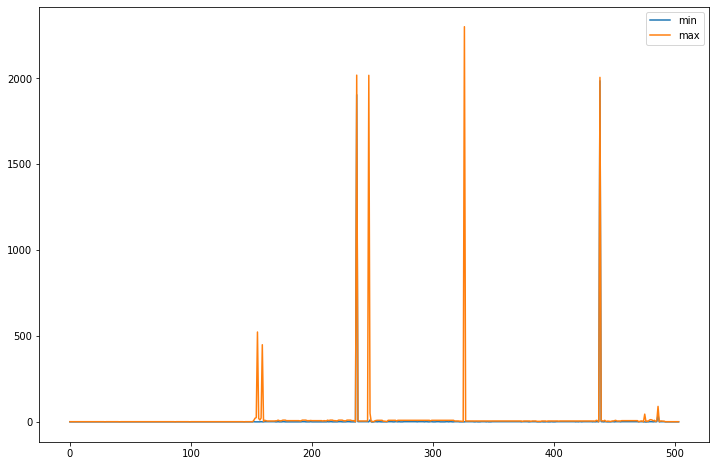

In [64]:
fig = plt.figure(figsize=(12,8))
#plt.figure()
plt.plot(clean_Azdias.describe().loc['min'].values, label='min')
plt.plot(clean_Azdias.describe().loc['max'].values, label='max')
plt.legend()
plt.show()

In [65]:
# Apply feature scaling to the general population demographics data.

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# store them in this dataframe
Azdias_scaled=pd.DataFrame(scaler.fit_transform(clean_Azdias.astype(float)))

# get same features and indices
Azdias_scaled.columns = New_Azdias_df.columns
Azdias_scaled.index = New_Azdias_df.index

In [66]:
Azdias_scaled.describe()

,AGER_TYP_-1,AGER_TYP_0,AGER_TYP_1,AGER_TYP_2,AGER_TYP_3,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,...,WOHNLAGE_3.0,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0
count,4.640980e+05,4.640980e+05,4.640980e+05,4.640980e+05,4.640980e+05,4.640980e+05,4.640980e+05,4.640980e+05,4.640980e+05,4.640980e+05,...,4.640980e+05,4.640980e+05,4.640980e+05,4.640980e+05,4.640980e+05,4.640980e+05,4.640980e+05,4.640980e+05,4.640980e+05,4.640980e+05
mean,-1.979762e-15,1.308709e-15,-4.917322e-15,-7.506244e-15,1.542216e-15,-4.240216e-16,9.448790e-15,-1.225877e-14,-1.319659e-15,4.246935e-15,...,2.601830e-15,6.030447e-15,2.747356e-15,7.124898e-15,-1.006960e-14,-1.496617e-14,-5.230723e-15,-1.078823e-15,-2.002342e-14,-1.231953e-14
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.331492e+00,-1.198600e-01,-4.056200e-01,-4.387437e-01,-2.139443e-01,-3.532354e-01,-4.798769e-01,-4.806753e-01,-5.797836e-01,-4.015986e-01,...,-6.872127e-01,-4.326069e-01,-2.925387e-01,-5.567973e-01,-1.016570e-01,-1.441520e+00,-3.095967e-01,-2.571475e-01,-2.679923e-01,-3.486657e-01
25%,-1.331492e+00,-1.198600e-01,-4.056200e-01,-4.387437e-01,-2.139443e-01,-3.532354e-01,-4.798769e-01,-4.806753e-01,-5.797836e-01,-4.015986e-01,...,-6.872127e-01,-4.326069e-01,-2.925387e-01,-5.567973e-01,-1.016570e-01,-1.441520e+00,-3.095967e-01,-2.571475e-01,-2.679923e-01,-3.486657e-01
50%,7.510374e-01,-1.198600e-01,-4.056200e-01,-4.387437e-01,-2.139443e-01,-3.532354e-01,-4.798769e-01,-4.806753e-01,-5.797836e-01,-4.015986e-01,...,-6.872127e-01,-4.326069e-01,-2.925387e-01,-5.567973e-01,-1.016570e-01,6.937120e-01,-3.095967e-01,-2.571475e-01,-2.679923e-01,-3.486657e-01
75%,7.510374e-01,-1.198600e-01,-4.056200e-01,-4.387437e-01,-2.139443e-01,-3.532354e-01,-4.798769e-01,-4.806753e-01,1.724781e+00,-4.015986e-01,...,1.455153e+00,-4.326069e-01,-2.925387e-01,-5.567973e-01,-1.016570e-01,6.937120e-01,-3.095967e-01,-2.571475e-01,-2.679923e-01,-3.486657e-01
max,7.510374e-01,8.343064e+00,2.465362e+00,2.279235e+00,4.674114e+00,2.830974e+00,2.083868e+00,2.080406e+00,1.724781e+00,2.490048e+00,...,1.455153e+00,2.311567e+00,3.418351e+00,1.795986e+00,9.837001e+00,6.937120e-01,3.230009e+00,3.888819e+00,3.731451e+00,2.868077e+00


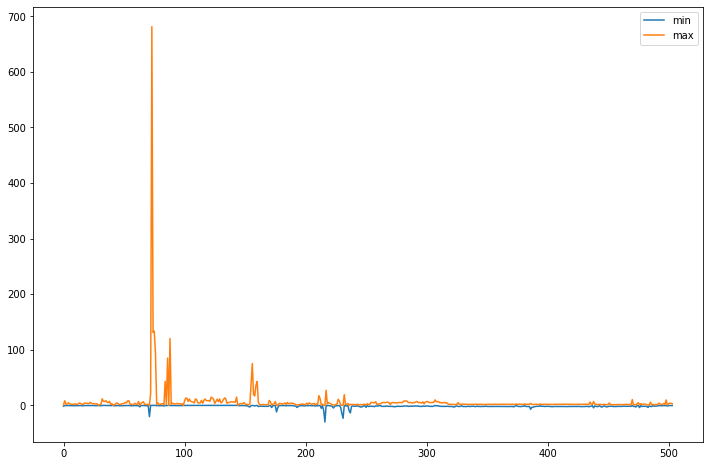

In [67]:
fig = plt.figure(figsize=(12,8))
plt.plot(Azdias_scaled.describe().loc['min'].values, label='min')
plt.plot(Azdias_scaled.describe().loc['max'].values, label='max')
plt.legend()
plt.show()

In [68]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

### Benchmark Using silhouette_score For Feature scaing 

In [88]:
# %%time
# range_n_clusters = [2, 3, 4, 5, 6]

# for n_clusters in range_n_clusters:
    
#     clusterer = KMeans(n_clusters=n_clusters)
#     preds = clusterer.fit_predict(Azdias_scaled)
#     centers = clusterer.cluster_centers_

#     score = silhouette_score(Azdias_scaled, preds)
#     print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

For n_clusters = 2, silhouette score is 0.048136788607822285)
For n_clusters = 3, silhouette score is 0.034845488254546066)
For n_clusters = 4, silhouette score is 0.0381720744295519)
For n_clusters = 5, silhouette score is 0.03146166789974724)
For n_clusters = 6, silhouette score is 0.02774136624361057)
CPU times: user 17h 21min 53s, sys: 1h 24min 5s, total: 18h 45min 59s
Wall time: 13h 2min 31s


### Define a PCA Model

To create a PCA model, I'll use the built-in SageMaker resource. A SageMaker estimator requires a number of parameters to be specified; these define the type of training instance to use and the model hyperparameters. A PCA model requires the following constructor arguments:

role: The IAM role, which was specified, above.
train_instance_count: The number of training instances (typically, 1).
train_instance_type: The type of SageMaker instance for training.
num_components: An integer that defines the number of PCA components to produce.
sagemaker_session: The session used to train on SageMaker.
Documentation on the PCA model can be found here.

Below, I first specify where to save the model training data, the output_path.

In [69]:
Azdias_scaled.head()

,AGER_TYP_-1,AGER_TYP_0,AGER_TYP_1,AGER_TYP_2,AGER_TYP_3,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,...,WOHNLAGE_3.0,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0
1,0.751037,-0.11986,-0.40562,-0.438744,-0.213944,-0.353235,-0.479877,2.080406,-0.579784,-0.401599,...,-0.687213,-0.432607,-0.292539,-0.556797,-0.101657,0.693712,-0.309597,-0.257147,-0.267992,-0.348666
3,0.751037,-0.11986,-0.40562,-0.438744,-0.213944,-0.353235,-0.479877,-0.480675,-0.579784,2.490048,...,1.455153,-0.432607,-0.292539,-0.556797,-0.101657,-1.441520,3.230009,-0.257147,-0.267992,-0.348666
4,-1.331492,-0.11986,-0.40562,-0.438744,4.674114,-0.353235,2.083868,-0.480675,-0.579784,-0.401599,...,-0.687213,-0.432607,-0.292539,1.795986,-0.101657,0.693712,-0.309597,-0.257147,-0.267992,-0.348666
6,0.751037,-0.11986,-0.40562,-0.438744,-0.213944,-0.353235,-0.479877,2.080406,-0.579784,-0.401599,...,-0.687213,-0.432607,-0.292539,-0.556797,-0.101657,0.693712,-0.309597,-0.257147,-0.267992,-0.348666
8,0.751037,-0.11986,-0.40562,-0.438744,-0.213944,-0.353235,-0.479877,-0.480675,1.724781,-0.401599,...,-0.687213,-0.432607,-0.292539,1.795986,-0.101657,0.693712,-0.309597,-0.257147,-0.267992,-0.348666


In [70]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(Azdias_scaled)
X_pca = pca.transform(Azdias_scaled)

In [71]:
'{:0.2f}'.format(pca.explained_variance_ratio_.sum())

'1.00'

In [72]:
variance_total = 0
components_to_retain = -1
for i, v in enumerate(pca.explained_variance_ratio_):
    variance_total += v
    if variance_total >= 0.90:
        components_to_retain = i
        break

#components_to_retain
print('components_to_retain number is', components_to_retain) 

components_to_retain number is 251


In [73]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(components_to_retain)
pca.fit(Azdias_scaled)
X_pca = pca.transform(Azdias_scaled) 
'{:0.2f}'.format(pca.explained_variance_ratio_.sum())
    

'0.90'

In [74]:
def dim_reduction(df, pca):
    '''Reduce dimensionality of data using pca decomposition.
       :param df: Normalized customer dataframe; 
       :param pca: principal component analysis.
       return transformed dataframe and pca model
       '''
    
    min_features = 251
    pca = pca(n_components = min_features)
    pca.fit(df)
    transformed_df = pca.transform(df)
    columns = ['c_{}'.format(i) for i in range(min_features)]
    varianace = pca.explained_variance_ratio_.sum()
    print ('The dataframe has {} features and it is transformed to {} with Explained varainace ration of {:0.2f}'.format(df.shape[1],
                                                                                                                    min_features,
                                                                                                                    varianace))
    
    return pca, transformed_df

In [75]:
pca, pca_azdias = dim_reduction(Azdias_scaled, pca=PCA)

The dataframe has 504 features and it is transformed to 251 with Explained varainace ration of 0.90


### Using silhouette_score for clustering  

In [97]:
# %%time
# range_n_clusters = [2, 3, 4, 5, 6]

# for n_clusters in range_n_clusters:
    
#     clusterer = KMeans(n_clusters=n_clusters)
#     preds = clusterer.fit_predict(pca_azdias)
#     centers = clusterer.cluster_centers_

#     score = silhouette_score(pca_azdias, preds)
#     print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

For n_clusters = 2, silhouette score is 0.053798456867878625)
For n_clusters = 3, silhouette score is 0.039349699790037274)
For n_clusters = 4, silhouette score is 0.043010961524264646)
For n_clusters = 5, silhouette score is 0.03588469074109654)
For n_clusters = 6, silhouette score is 0.03192460736412464)
CPU times: user 7h 36min 9s, sys: 58min 5s, total: 8h 34min 14s
Wall time: 6h 4min 24s


In [76]:
def display_component(v, features_list, component_num, n_weights=10):
    
    # get index of component (last row - component_num)
    row_idx = component_num

    # get the list of weights from a row in v, dataframe
    v_1_row = v.iloc[:, row_idx]
    v_1 = np.squeeze(v_1_row.values)

    # match weights to features in counties_scaled dataframe, using list comporehension
    comps = pd.DataFrame(list(zip(v_1, features_list)), 
                         columns=['weights', 'features'])

    # we'll want to sort by the largest n_weights
    # weights can be neg/pos and we'll sort by magnitude
    comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
    sorted_weight_data = comps.sort_values('abs_weights', ascending=False).head(n_weights)

    # display using seaborn
    ax=plt.subplots(figsize=(10,6))
    ax=sns.barplot(data=sorted_weight_data, 
                   x="weights", 
                   y="features", 
                   palette="Blues_d")
    ax.set_title("PCA Component Makeup, Component #" + str(component_num))
    plt.show()

In [77]:
# Creating components dataframe
comp_azdias = pca.components_
v_a = pd.DataFrame(data=comp_azdias)

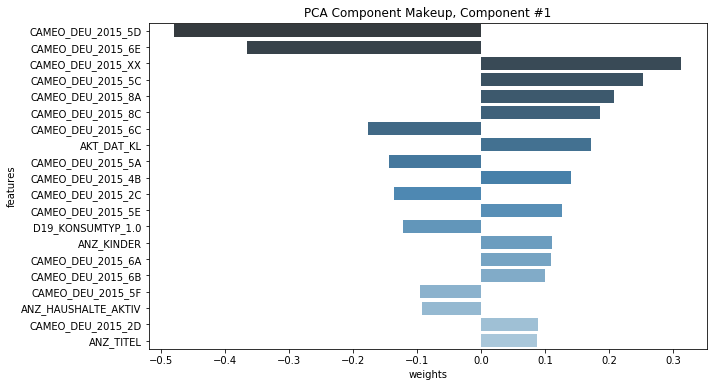

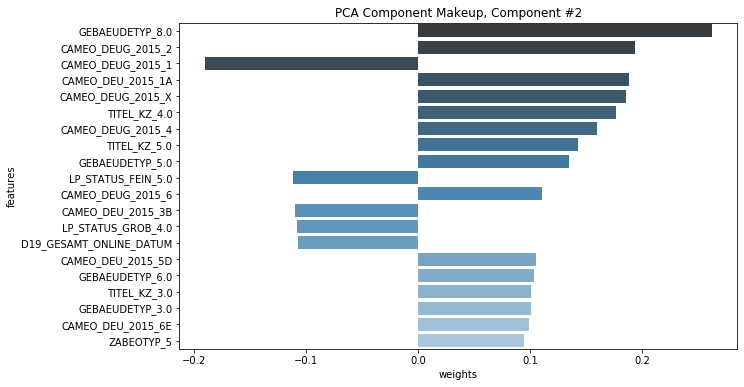

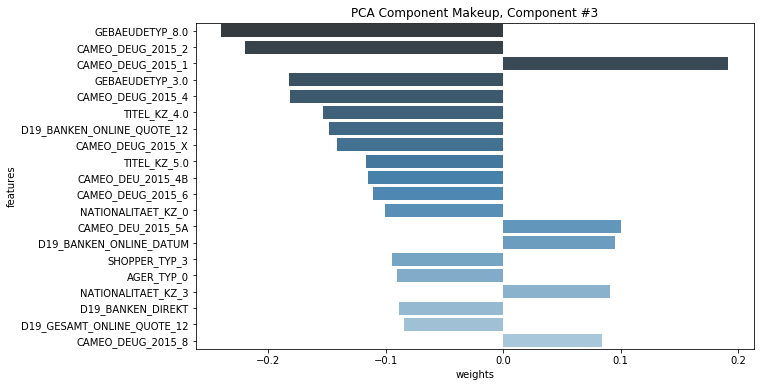

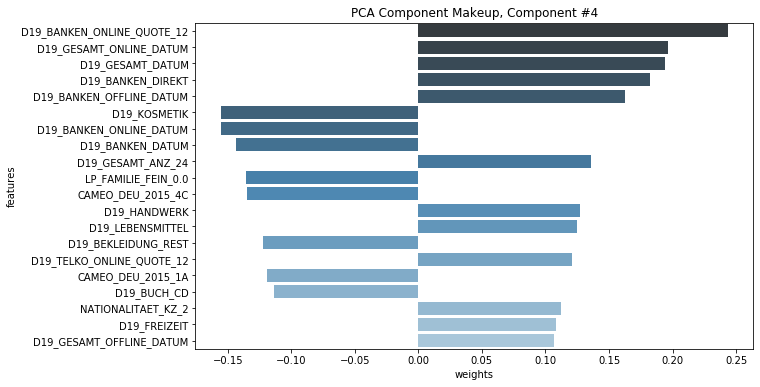

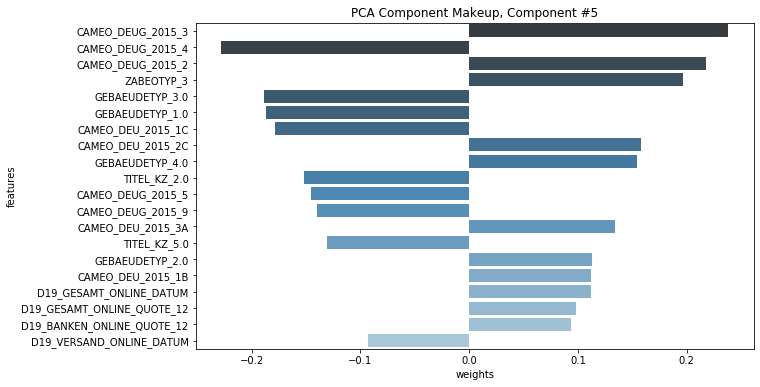

In [78]:
# Display makeup of first component
for i in range(1, 6):
    display_component(v_a, Azdias_scaled.columns.values, component_num=i, n_weights=20)

### Step 3: Clustering
Step 3.1: Apply Clustering to General Population
You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

Use sklearn's KMeans class to perform k-means clustering on the PCA-transformed data.
Then, compute the average difference from each point to its assigned cluster's center. Hint: The KMeans object's .score() method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.

Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. Warning: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.

Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.


I. Determining the optimal number of clusters for k-means clustering
For each k value, we will initialise k-means and use the inertia attribute to identify the sum of squared distances of samples to the nearest cluster centre.

In [79]:
# %%time
# Sum_of_squared_distances = []
# K = range(1,15)
# for k in K:
#     km = KMeans(n_clusters=k)
#     print ('Training k={}...'.format(k))
#     km = km.fit(pca_azdias)
#     Sum_of_squared_distances.append(km.inertia_)

In [80]:
# plt.plot(K, Sum_of_squared_distances, 'bo-')
# plt.xlabel('k')
# plt.ylabel('Sum of squared distances for azdias dataframe')
# plt.title('Elbow Method For Optimal k')
# plt.grid(alpha=0.8)
# plt.show()

In [81]:
km = KMeans(n_clusters=2, random_state=42)

In [82]:
km_azdias = km.fit(pca_azdias)

In [83]:
labels_azdias = km_azdias.predict(pca_azdias)

In [84]:
class_count = pd.Series(labels_azdias).value_counts()

cls_azdias = pd.DataFrame({'cluster': class_count.index,
                           '% of data': 100*class_count.values/len(labels_azdias)})
cls_azdias['data'] = 'general population'

# print cls_azdias
cls_azdias

,cluster,% of data,data
0,1,58.224341,general population
1,0,41.775659,general population


### Step 3.2: Apply All Steps to the Customer Data

In [85]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customer_clean = clean_data(Customers_df)

In [86]:
customer_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140903 entries, 0 to 140902
Columns: 506 entries, AGER_TYP_-1 to PLZ8_BAUMAX_5.0
dtypes: float64(253), int64(88), object(3), uint8(162)
memory usage: 391.6+ MB


In [87]:
customer_clean.head()

,AGER_TYP_-1,AGER_TYP_0,AGER_TYP_1,AGER_TYP_2,AGER_TYP_3,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,...,WOHNLAGE_3.0,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0
0,0,0,0,1,0,0,0,0,0,1,...,0,0,0,1,0,1,0,0,0,0
1,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,1,0,0,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
4,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0


In [88]:
# Remove additional columns
orig_customers = customer_clean[['LNR', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE',
                               'PRODUCT_GROUP']]

customer_clean.drop(['LNR', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE',
                    'PRODUCT_GROUP'], axis=1, inplace=True)

In [89]:
customer_clean.shape

(140903, 502)

In [90]:
clean_Azdias.shape

(464098, 504)

In [91]:
#  Check for missing column in `new_customers`
mask = clean_Azdias.columns.isin(customer_clean.columns)

miss_att = list(clean_Azdias.columns[~mask])
miss_att

['TITEL_KZ_2.0', 'GEBAEUDETYP_5.0']

In [92]:
customer_clean['TITEL_KZ_2.0'] = 0

In [93]:
customer_clean['GEBAEUDETYP_5.0'] = 0

In [94]:
#  Check for missing column in `new_customers`
mask = clean_Azdias.columns.isin(customer_clean.columns)

miss_att = list(clean_Azdias.columns[~mask])
miss_att

[]

In [95]:
customer_clean.isna().sum(axis=1)

0          1
1          1
2          6
3          1
4          1
5          1
6          1
7          4
8          1
9          1
10         1
11        64
12         1
13         1
14         1
15         1
16         1
17         1
18        64
19         1
20         1
21         8
22         1
23         1
24         1
25         2
26         1
27         1
28         1
29         1
          ..
140873     1
140874     1
140875     1
140876     1
140877     1
140878     1
140879     1
140880     1
140881     1
140882     5
140883     1
140884     1
140885     1
140886     1
140887     1
140888     1
140889     1
140890    67
140891     1
140892     1
140893     1
140894     1
140895     1
140896     1
140897     1
140898     1
140899    12
140900     1
140901     1
140902     1
Length: 140903, dtype: int64

In [96]:
clean_Azdias.shape

(464098, 504)

In [97]:
# replace missing value
customer_clean = pd.DataFrame(imp.transform(customer_clean.values),
                         columns=customer_clean.columns)

# scale customers variables
Customer_scaled = pd.DataFrame(scaler.transform(customer_clean.values),
                         columns=customer_clean.columns)

In [98]:
Customer_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140903 entries, 0 to 140902
Columns: 504 entries, AGER_TYP_-1 to GEBAEUDETYP_5.0
dtypes: float64(504)
memory usage: 541.8 MB


In [99]:
Azdias_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 464098 entries, 1 to 791985
Columns: 504 entries, AGER_TYP_-1 to PLZ8_BAUMAX_5.0
dtypes: float64(504)
memory usage: 1.7 GB


In [100]:
# cluster predictions for the  customer demographics data.
customers_pca = pca.transform(Customer_scaled)
labels_customers = km.predict(customers_pca)

In [101]:
cus_class = pd.Series(labels_customers).value_counts()

cls_customers = pd.DataFrame({'cluster': cus_class.index,
                              '% of data': 100*cus_class.values/len(labels_customers)})
cls_customers['data'] = 'customers data'

# print cls_azdias
cls_customers

,cluster,% of data,data
0,1,94.91849,customers data
1,0,5.08151,customers data


In [102]:
import matplotlib.pyplot as plt

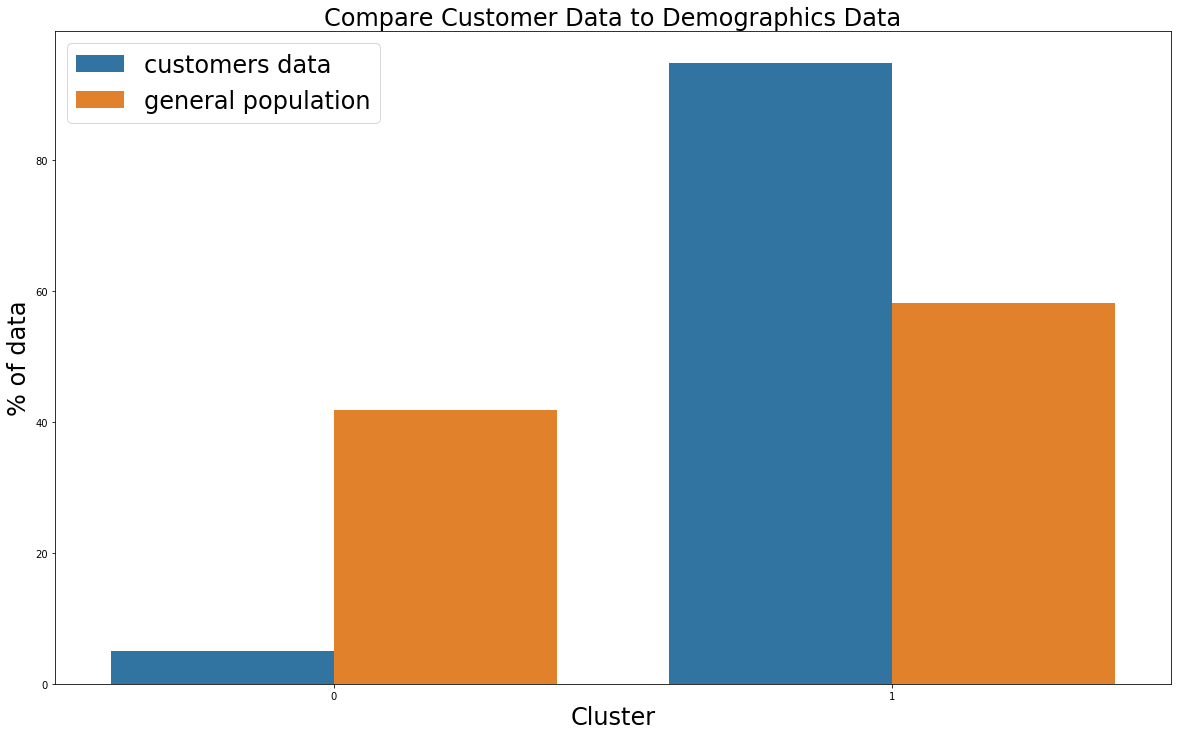

In [103]:
plt.figure(figsize=(20, 12))
sns.barplot(x="cluster", y="% of data", hue="data",
            data=pd.concat([cls_customers, cls_azdias]))
plt.xlabel('Cluster', fontsize=24)
plt.ylabel('% of data', fontsize=24)
plt.title('Compare Customer Data to Demographics Data', fontsize=24)
plt.legend(fontsize=24)
plt.show()

In [108]:
# Select People in the target class
target_class = [1]
target_pca = pca.inverse_transform(pca_azdias[np.isin(labels_azdias, target_class)])
target_azdias = scaler.inverse_transform(target_pca).round()
target_azdias = pd.DataFrame(target_azdias, columns = New_Azdias_df.columns)
target_azdias.describe()


,AGER_TYP_-1,AGER_TYP_0,AGER_TYP_1,AGER_TYP_2,AGER_TYP_3,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,...,WOHNLAGE_3.0,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0
count,270218.000000,270218.000000,270218.000000,270218.000000,270218.000000,270218.000000,270218.000000,270218.000000,270218.000000,270218.000000,...,270218.000000,270218.000000,270218.000000,270218.000000,270218.000000,270218.000000,270218.000000,270218.000000,270218.000000,270218.000000
mean,0.607835,0.015576,0.173171,0.166251,0.040101,0.113527,0.210800,0.172672,0.237627,0.145679,...,0.267266,0.079965,0.033096,0.379105,0.017190,0.952190,0.035164,0.004522,0.002887,0.006528
std,0.488636,0.123830,0.378396,0.372306,0.196196,0.317236,0.407878,0.377964,0.425630,0.352784,...,0.442533,0.271240,0.178886,0.485241,0.129978,0.213537,0.184195,0.067096,0.053649,0.080532
min,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,...,-0.000000,0.000000,0.000000,-1.000000,-0.000000,-1.000000,0.000000,-0.000000,-0.000000,0.000000
25%,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-0.000000,-0.000000,1.000000,0.000000,0.000000,0.000000,-0.000000
75%,1.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,-0.000000,0.000000,-0.000000
max,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000


In [109]:
# Select People in the no target class
no_target_class = [0]
no_target_pca = pca.inverse_transform(pca_azdias[np.isin(labels_azdias, no_target_class)])
no_target_azdias = scaler.inverse_transform(no_target_pca).round()
no_target_pca = pd.DataFrame(no_target_pca, columns=New_Azdias_df.columns)
no_target_pca.describe()

,AGER_TYP_-1,AGER_TYP_0,AGER_TYP_1,AGER_TYP_2,AGER_TYP_3,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,...,WOHNLAGE_3.0,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0
count,193880.000000,193880.000000,193880.000000,193880.000000,193880.000000,193880.000000,193880.000000,193880.000000,193880.000000,193880.000000,...,193880.000000,193880.000000,193880.000000,193880.000000,193880.000000,193880.000000,193880.000000,193880.000000,193880.000000,193880.000000
mean,0.099940,-0.016201,-0.127602,-0.018642,0.025558,-0.010558,-0.084437,0.054107,0.044190,-0.028368,...,0.159110,0.295740,0.236552,-0.469797,-0.095337,-0.814105,0.252412,0.323909,0.357199,0.458460
std,0.932530,0.925260,0.842996,0.965018,1.035817,0.974224,0.911708,1.030354,1.009599,0.965515,...,1.048415,1.193736,1.263126,0.471220,0.366417,0.796803,1.251015,1.339883,1.351916,1.319384
min,-2.154340,-0.686195,-1.949777,-1.973699,-0.972668,-1.081244,-1.268880,-2.377111,-1.296983,-0.895861,...,-1.170239,-1.141303,-1.180120,-1.692331,-2.020776,-2.515352,-1.846441,-1.810581,-1.960136,-1.512345
25%,-0.997981,-0.164267,-0.500310,-0.512790,-0.311865,-0.441451,-0.555454,-0.537953,-0.637014,-0.456020,...,-0.706147,-0.478291,-0.382357,-0.725372,-0.300222,-1.410475,-0.417468,-0.374646,-0.363140,-0.399846
50%,0.547630,-0.116834,-0.372745,-0.387425,-0.195815,-0.317862,-0.427497,-0.422714,-0.473944,-0.381139,...,-0.588214,-0.343718,-0.231685,-0.544965,-0.118692,-1.137063,-0.202553,-0.135549,-0.123714,-0.185216
75%,0.797808,-0.069364,-0.224263,-0.213992,-0.073185,-0.176464,-0.265366,-0.237383,1.391339,-0.288129,...,1.418907,2.042528,-0.041378,-0.344319,0.075375,0.002696,0.059862,0.152197,0.146777,1.763106
max,2.770836,8.513220,3.031181,2.770279,5.140578,3.464493,2.837186,2.622272,2.906310,2.904475,...,1.840651,2.957121,4.487879,2.661551,9.234024,1.676970,3.787214,4.531360,4.778683,3.875697


In [110]:
target_azdias.head()

,AGER_TYP_-1,AGER_TYP_0,AGER_TYP_1,AGER_TYP_2,AGER_TYP_3,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,...,WOHNLAGE_3.0,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0
0,1.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,1.0,-0.0,-0.0,...,-0.0,0.0,0.0,0.0,-0.0,1.0,0.0,-0.0,-0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,1.0,...,1.0,-0.0,0.0,0.0,-0.0,0.0,1.0,-0.0,0.0,0.0
2,-0.0,0.0,0.0,0.0,1.0,0.0,1.0,-0.0,-0.0,-0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,-0.0,-0.0,-0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,0.0,-0.0,1.0,0.0,0.0,-0.0,-0.0
4,1.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,1.0,-0.0,...,0.0,0.0,0.0,1.0,-0.0,1.0,-0.0,0.0,0.0,0.0


In [111]:
no_target_pca.head()

,AGER_TYP_-1,AGER_TYP_0,AGER_TYP_1,AGER_TYP_2,AGER_TYP_3,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,...,WOHNLAGE_3.0,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0
0,-1.246925,8.320120,-0.577991,-0.393998,-0.186183,2.817562,-0.476243,-0.552629,-0.676016,-0.336878,...,-0.666004,-0.561404,3.209709,-0.289934,-0.067186,-1.237087,3.272002,-0.196480,-0.698132,-0.395918
1,0.640753,-0.151106,-0.276970,-0.324599,-0.361356,-0.569651,-0.712563,-0.376253,1.912727,-0.406158,...,1.428472,-0.581850,-0.389120,-0.843176,0.537110,-1.043066,-0.115097,-0.501772,3.375615,-0.649703
2,-0.039365,-0.002103,0.027084,-0.072293,0.177512,-0.077886,0.056017,-0.688400,1.430582,-0.444073,...,-0.541304,-0.477939,-0.359038,-0.300969,0.060150,-0.805524,-0.250253,-0.682428,-0.915033,2.706391
3,0.785224,-0.172458,-0.265090,-0.567442,-0.271615,-0.339539,-0.270773,-0.467260,1.481748,-0.396992,...,-0.683564,-0.296670,-0.014405,-0.747505,0.191751,0.355894,-0.107562,-0.012041,-0.236007,-0.239244
4,0.892007,-0.169634,-0.511445,-0.525720,-0.179481,2.674643,-0.579402,-0.466332,-0.384742,-0.415799,...,-0.556628,2.284149,-0.393349,-0.709671,-0.729432,-1.585411,-0.086847,-0.187016,-0.327698,2.876026


In [ ]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
# mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
# mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')